# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with GDP data taken from the International Monetary Fund.

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. XXXXXX
2. YYYYYY
3. ZZZZZZ

API key: S4fKTjESiijBFS7URg8z

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

In [319]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import world_bank_data as wb
import wbgapi as wba
import datetime
sns.set()
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import logging
import country_converter as coco

pd.set_option('display.max_rows', None)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Problem 1 - Data Handling
The basis of your work will be the following GDP dataset:

In [320]:
gdp = pd.read_csv("GDP_IMF.csv", sep=";")
gdp.sample(20)

Country  year        GDP
2071                          Benin  2001      3.666
2156                         Malawi  2001      4.178
8025                  Cote d'Ivoire  2027    103.889
3668                         Bhutan  2008       1.26
3619                      Caribbean  2007     74.671
1514                    Saint Lucia  1998      0.877
1065                     Seychelles  1996      0.503
4049                       Thailand  2009    281.399
2275  Major advanced economies (G7)  2001  21836.188
5018                        Algeria  2014     213.81
8119                       Portugal  2027    309.927
7454                Solomon Islands  2024      1.801
1538       Taiwan Province of China  1998    279.964
1293                     Seychelles  1997      0.563
5909                  South America  2017   3872.562
2052                    Afghanistan  2001    no data
208                Pacific Islands   1992      9.022
3289                        Lesotho  2006      1.519
3258                         Greece  2006    271.254
1099                        Uruguay  1996     24.625

#### a)
As you can see, there are many missing values in the data. <br>
Before you can continue, you need to handle them. Proceed as follows:
- Delete those countries with no data at all (if any)
- Either delete the missing years for each country or use the years close by to approximate the missing value <br> *Example: Year 2004 is missing, but 2003 and 2005 are available; use the mean of GDP in 2003 and 2005 to replace missing year 2004.*

Replace name of the Congos and remove additional information

In [321]:
gdp.groupby('Country').filter(lambda x: all(x['GDP']=='no data'))

Empty DataFrame
Columns: [Country, year, GDP]
Index: []

All countrys have atleast some years with GDP data

In [322]:
gdp.groupby('year').filter(lambda x: all(x['GDP']=='no data'))

Empty DataFrame
Columns: [Country, year, GDP]
Index: []

All years have atleast some countrys with GDP data

In [323]:
gdp.sort_values(by=['Country', 'year'], inplace=True)

In [324]:
gdp[gdp['Country']=='Sao Tome und Principe'].head(40)

Country  year    GDP
169   Sao Tome und Principe  1992  0.096
397   Sao Tome und Principe  1993  0.127
625   Sao Tome und Principe  1994  0.132
853   Sao Tome und Principe  1995  0.104
1081  Sao Tome und Principe  1996  0.136
1309  Sao Tome und Principe  1997  0.093
1537  Sao Tome und Principe  1998  0.073
1765  Sao Tome und Principe  1999  0.078
1993  Sao Tome und Principe  2000  0.077
2221  Sao Tome und Principe  2001  0.072
2449  Sao Tome und Principe  2002   0.08
2677  Sao Tome und Principe  2003  0.096
2905  Sao Tome und Principe  2004  0.104
3133  Sao Tome und Principe  2005  0.125
3361  Sao Tome und Principe  2006  0.133
3589  Sao Tome und Principe  2007  0.145
3817  Sao Tome und Principe  2008  0.188
4045  Sao Tome und Principe  2009  0.188
4273  Sao Tome und Principe  2010  0.197
4501  Sao Tome und Principe  2011  0.233
4729  Sao Tome und Principe  2012  0.253
4957  Sao Tome und Principe  2013  0.303
5185  Sao Tome und Principe  2014  0.349
5413  Sao Tome und Principe  2015  0.318
5641  Sao Tome und Principe  2016  0.348
5869  Sao Tome und Principe  2017  0.376
6097  Sao Tome und Principe  2018  0.416
6325  Sao Tome und Principe  2019  0.431
6553  Sao Tome und Principe  2020  0.477
6781  Sao Tome und Principe  2021  0.531
7009  Sao Tome und Principe  2022  0.552
7237  Sao Tome und Principe  2023  0.625
7465  Sao Tome und Principe  2024  0.663
7693  Sao Tome und Principe  2025  0.691
7921  Sao Tome und Principe  2026  0.724
8149  Sao Tome und Principe  2027  0.786
8377  Sao Tome und Principe  2028  0.846

In [325]:
# Replace 'no data' with nan values and convert to float
gdp['GDP'] = gdp['GDP'].replace('no data', np.nan).astype(float)

# Set multi-index and sort
gdp.set_index(['Country', 'year'], inplace=True)
gdp.sort_index(inplace=True)

# Generate a full index of all year combinations for each country
all_years = range(gdp.index.get_level_values('year').min(), gdp.index.get_level_values('year').max() + 1)
full_index = pd.MultiIndex.from_product([gdp.index.get_level_values('Country').unique(), all_years], 
                                        names=['Country', 'year'])

# Reindex and interpolate
gdp = gdp.reindex(full_index)
gdp['GDP'] = gdp.groupby('Country', group_keys=False)['GDP'].apply(lambda group: group.interpolate(method='linear', limit_direction='both'))

# Reset the index
gdp.reset_index(inplace=True)


#### b)
We are only interested in the data on a country level and for years already passed. <br>
The dataset, however, also contains information on whole regions such as the EU or G7. <br>
It also contains predictions for GDP in the upcoming years. <br>
Delete these observations from the data. <br>
*Hint: Get a list of all unique values of the Country column.*

In [326]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Caribbean',
       'Central African Republic', 'Central America',
       'Central Asia and the Caucasus', 'Chad', 'Chile',
       "China, People's Republic of", 'Colombia', 'Comoros',
       'Congo, Dem. Rep. of the', 'Congo, Republic of ', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern E

In [327]:
gdp['Country'][gdp['Country'] == 'Congo, Dem. Rep. of the'] = 'Democratic Republic of Congo'
gdp['Country'][gdp['Country'] == 'Congo, Republic of '] = 'Republic of Congo'
gdp['Country'][gdp['Country'] == 'Taiwan Province of China'] = 'Taiwan SAR'
gdp['Country'][gdp['Country'] == 'Lao P.D.R.'] = 'Lao People\'s Democratic Republic'

C:\Users\nicho\AppData\Local\Temp\ipykernel_66040\1739472201.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicho\AppData\Local\Temp\ipykernel_66040\1739472201.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicho\AppData\Local\Temp\ipykernel_66040\1739472201.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicho\AppData\Local\Temp\ipykernel_66040\1739472201.py:4: SettingWithCopyWarning:


A value

In [328]:
gdp['Country'] = gdp['Country'].str.split(',').str[0]

In [329]:
gdp['Country'].unique()

array(['ASEAN-5', 'Advanced economies', 'Afghanistan', 'Africa (Region)',
       'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Asia and Pacific', 'Australia',
       'Australia and New Zealand', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean', 'Central African Republic',
       'Central America', 'Central Asia and the Caucasus', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros',
       'Democratic Republic of Congo', 'Republic of Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'East Asia',
       'Eastern Europe ', 'Ecuador', 'Egypt', 'E

In [330]:
import requests
from bs4 import BeautifulSoup

# Send a GET request
response = requests.get('https://www.imf.org/en/Countries')

# Parse the response content with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the country names
countries = [country.text for country in soup.select('a[href^="/en/Countries/"]')]

In [331]:
countries = countries[11:]

In [332]:
countries = [c.replace('Congo, Democratic Republic of the', 'Democratic Republic of Congo') for c in countries]
countries = [c.replace('Congo, Republic of', 'Republic of Congo') for c in countries]
countries = [c.replace('Syrian Arab Republic', 'Syria') for c in countries]
countries = [c.replace('Hong Kong Special Administrative Region', 'Hong Kong SAR') for c in countries]
countries = [c.replace('Macao Special Administrative Region', 'Macao SAR') for c in countries]

countries = [c.replace('North Macedonia', 'North Macedonia ') for c in countries]
countries = [c.replace('Türkiye', 'Tuerkiye') for c in countries]
countries = [c.replace('Côte d\'Ivoire', 'Cote d\'Ivoire') for c in countries]
countries.append('Taiwan SAR')
countries.append('Puerto Rico')
countries.append('Saint Kitts and Nevis')
countries.append('Saint Lucia')
countries.append('Saint Vincent and the Grenadines')
countries.append('Sao Tome und Principe')
countries.append('West Bank and Gaza')


In [333]:
countries = [country.split(',')[0] for country in countries]
len(countries)

205

In [334]:
len(gdp['Country'].unique())

228

In [335]:
missing_countries = gdp[~gdp['Country'].isin(countries)]

for country in missing_countries['Country'].unique():
    print(country)

ASEAN-5
Advanced economies
Africa (Region)
Asia and Pacific
Australia and New Zealand
Caribbean
Central America
Central Asia and the Caucasus
East Asia
Eastern Europe 
Emerging and Developing Asia
Emerging and Developing Europe
Emerging market and developing economies
Euro area
Europe
European Union
Latin America and the Caribbean
Major advanced economies (G7)
Middle East (Region)
Middle East and Central Asia
North Africa
North America
Other advanced economies
Pacific Islands 
South America
South Asia
Southeast Asia
Sub-Saharan Africa
Sub-Saharan Africa (Region) 
Western Europe
Western Hemisphere (Region)
World


In [336]:
gdp = gdp[gdp['Country'].isin(countries)]

In [337]:
len(gdp['Country'].unique())

196

In [338]:
gdp['year'].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028], dtype=int64)

In [339]:
gdp = gdp.drop(gdp[gdp['year']>2023].index)

In [340]:
len(gdp['year'].unique())

32

In [341]:
gdp.head()

Country  year    GDP
74  Afghanistan  1992  4.367
75  Afghanistan  1993  4.367
76  Afghanistan  1994  4.367
77  Afghanistan  1995  4.367
78  Afghanistan  1996  4.367

# Problem 2 - Data Visualization
#### a)
To get some first insights in the data, create meaningful plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

In [342]:
# Use plotly express to create an interactive scatter plot
fig = px.scatter(gdp, x=gdp['year'], y=gdp['GDP'], color='Country', hover_name='Country')

fig.update_layout(
    xaxis_title=f'Year',
    yaxis_title=f'GDP',
    title='Countries GDP in Billions [USD] (1992-2023)',
    showlegend=True
)

# Show the interactive plot
fig.show()

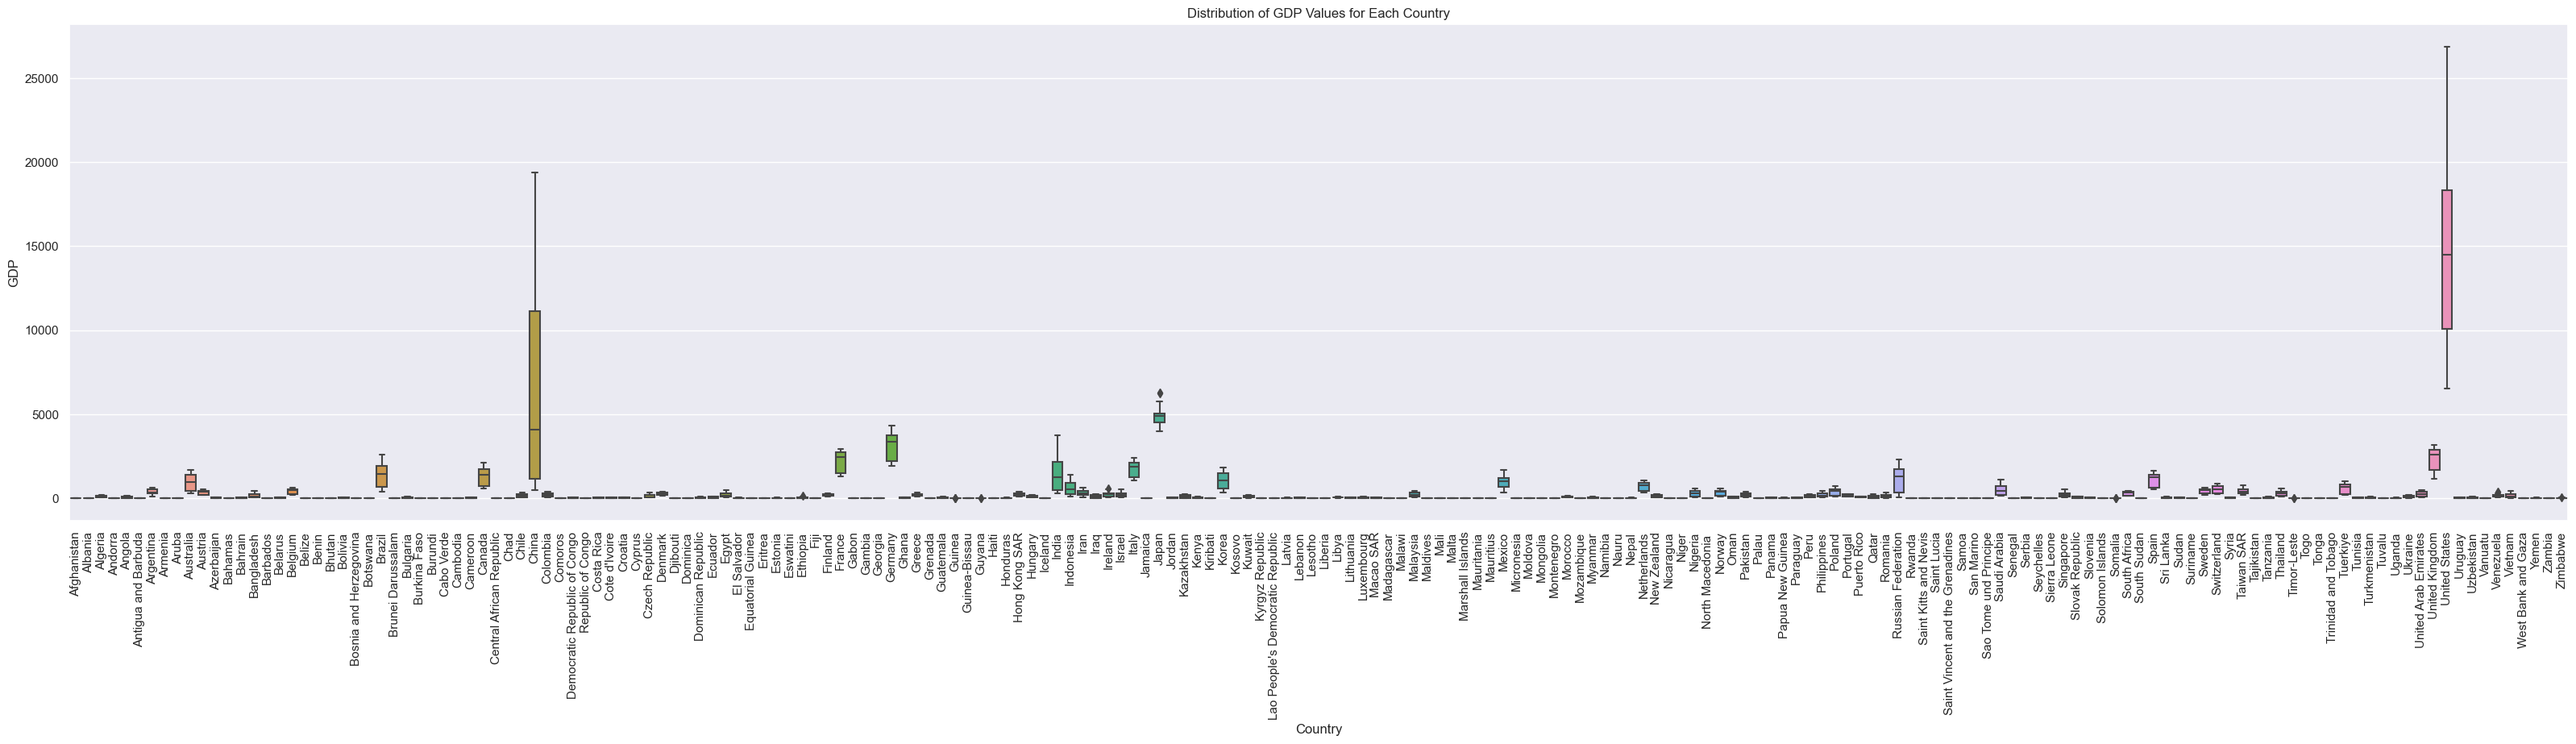

In [343]:
import seaborn as sns

plt.figure(figsize=(40, 8))
sns.boxplot(x='Country', y='GDP', data=gdp)
plt.title('Distribution of GDP Values for Each Country')
plt.xticks(rotation=90) # This makes the country names vertical so they don't overlap
plt.show()

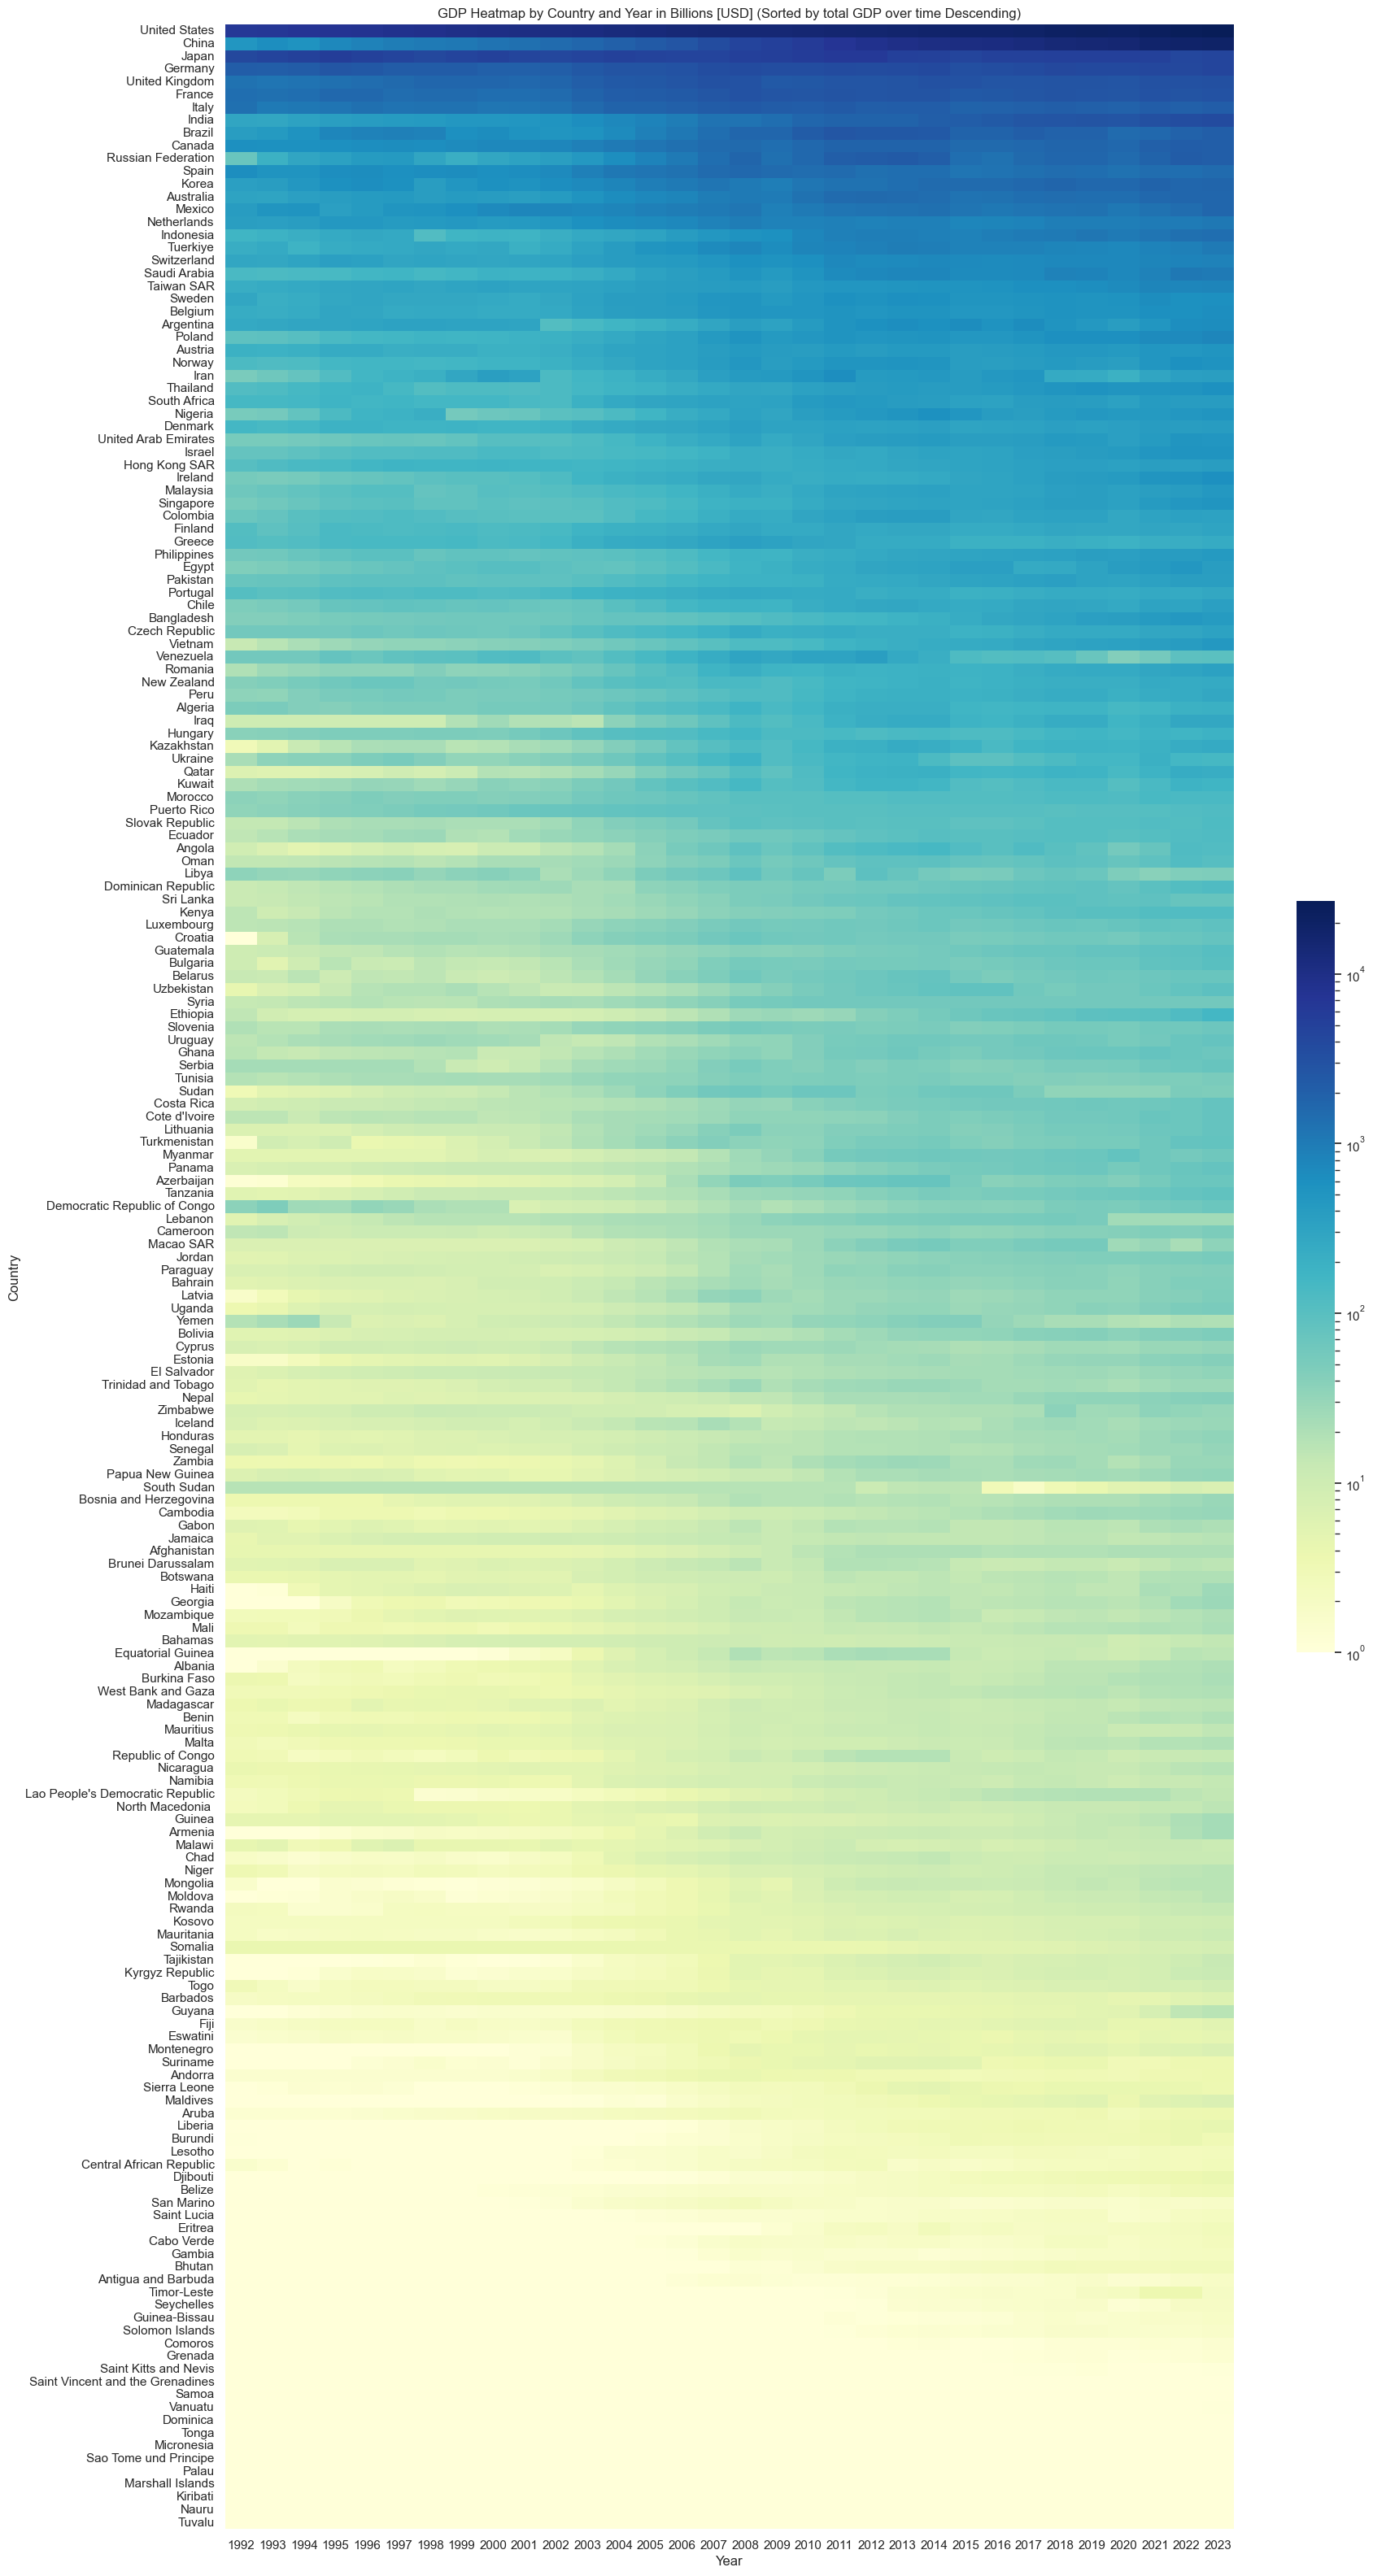

In [344]:
import matplotlib.colors as clrs


def heatmap_normal_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed
    sns.heatmap(pivot_data, cmap='YlGnBu', cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year')

    plt.show()

def heatmap_log_scaling_ordered_alphabetical():
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year (Log Scaling)')


def heatmap_log_scaling_ordered_gdp(): 
    pivot_data = gdp.pivot(index='Country', columns='year', values='GDP').fillna(0)

    # Calculate the total GDP for each country and sort by GDP in descending order
    total_gdp = pivot_data.sum(axis=1)
    sorted_countries = total_gdp.sort_values(ascending=False).index

    # Reorder the rows in the pivot_data DataFrame based on the sorted countries
    pivot_data_sorted = pivot_data.loc[sorted_countries]

    # Create a heatmap with log scaling for the legend
    plt.figure(figsize=(20, 40))
    sns.heatmap(pivot_data_sorted, cmap='YlGnBu', norm=clrs.LogNorm(vmin=1, vmax=pivot_data.values.max()), cbar_kws={"shrink": 0.3})
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.title('GDP Heatmap by Country and Year in Billions [USD] (Sorted by total GDP over time Descending)')
    plt.show()


#heatmap_normal_scaling_ordered_alphabetical()
#heatmap_log_scaling_ordered_alphabetical()
heatmap_log_scaling_ordered_gdp()

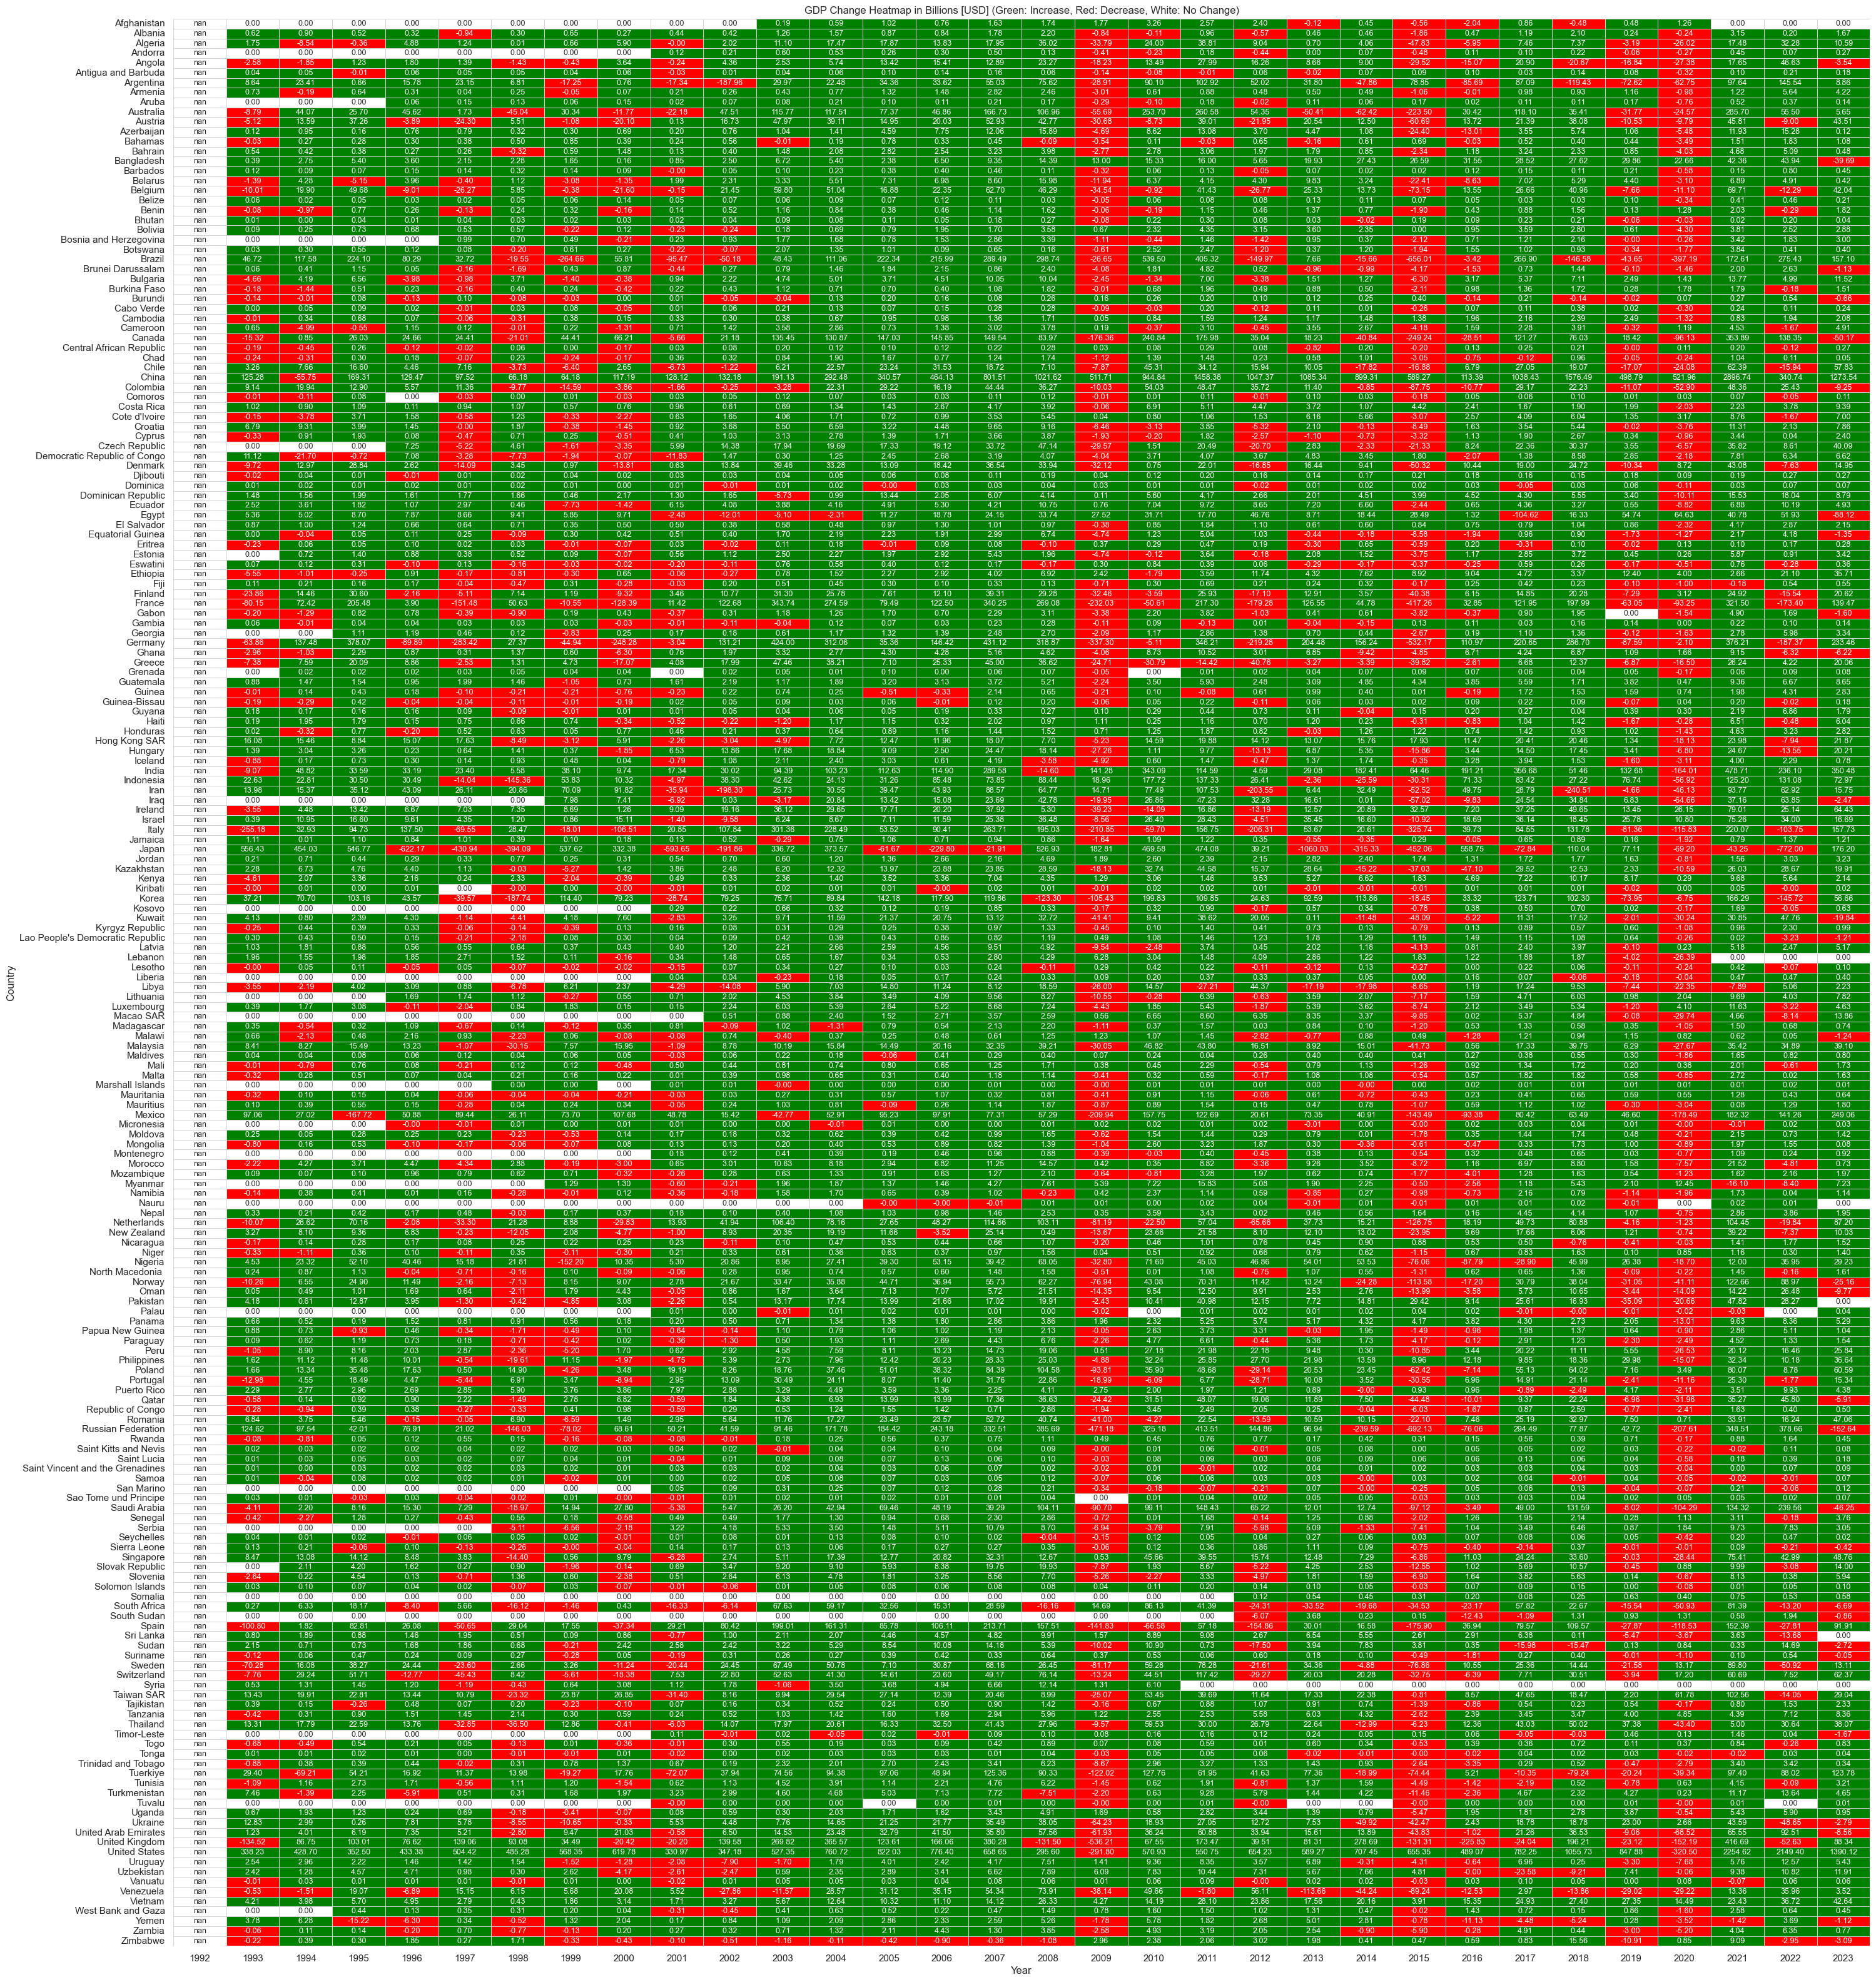

In [345]:

## Create a heatmap of the change in GDP from one year to the next for each country
dfh = gdp
# create a new column for the change in GDP from one year to the next
dfh['gdp_change'] = dfh.groupby('Country')['GDP'].diff()
dfh['gdp_change_category'] = np.where(dfh['gdp_change'] > 0, 'Increase', np.where(dfh['gdp_change'] < 0, 'Decrease', 'No Change'))

# create a mapper to map the gdp_change_category column to numerical values
mapper = {'Increase': 1, 'No Change': 0, 'Decrease': -1}

# Map the gdp_change_category column to numerical values
dfh['gdp_change_category'] = dfh['gdp_change_category'].map(mapper)

# Pivot the DataFrame to have years as columns and countries as index
df_pivot = dfh.pivot(index='Country', columns='year', values='gdp_change_category')

# Create a colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'white', 'green'])


## Calculate the absolute change in gdp from one year to the next as annotation for the heatmap
# Pivot the data to have each country's GDP as a separate column
pivot_data_labels = gdp.pivot(index='Country', columns='year', values='GDP')
# Calculate the change in GDP for each country from one year to the next
gdp_change_label = pivot_data_labels.diff(axis=1)


# Plot the heatmap
plt.figure(figsize=(35, 40))
sns.heatmap(df_pivot, annot=gdp_change_label, annot_kws={"fontsize":9}, cmap=cmap, cbar=False, linewidths=0.5, linecolor='lightgrey', fmt=".2f")
plt.xlabel('Year')
plt.ylabel('Country')
plt.title('GDP Change Heatmap in Billions [USD] (Green: Increase, Red: Decrease, White: No Change)')

plt.show()

In [346]:
%%capture
import bar_chart_race as bcr

# Assuming you have already loaded the data into a DataFrame named 'data'
# Let's say the columns are: 'Country', 'Year', 'GDP'

# Pivot the data to have each country's GDP as a separate column
pivot_data_race = gdp.pivot(index='Country', columns='year', values='GDP')
pivot_data_race.columns = pd.to_datetime(pivot_data_race.columns, format='%Y')

# Transpose the DataFrame to have years as columns and countries as rows
pivot_data_race = pivot_data_race.T


# Create the bar chart race animation
bcr.bar_chart_race(
    df=pivot_data_race,
    filename='highest_gdp_comparison.gif',
    orientation='h',       # Horizontal bars
    sort='desc',           # Sort bars in descending order at each frame
    n_bars=20,             # Number of bars (countries) to include in each frame
    steps_per_period=10,   # Number of steps (frames) per year
    period_length=500,     # Length of each period (milliseconds)
    title='Top 20 Countries with Highest GDPs in Billions (USD) with median',
    bar_label_size=7,      # Font size of bar labels
    tick_label_size=7,     # Font size of tick labels
    period_fmt='%Y',       # Show only the year for periodic steps
    shared_fontdict={'family': 'Helvetica', 'color': '.1'},  # Font settings
    filter_column_colors=True,  # Apply the color from the final frame to all frames
    perpendicular_bar_func='median',  # Set the median as the reference line
)

![SegmentLocal](highest_gdp_comparison.gif "segment")

#### b)
Pick a year with as little missing values as possible. <br>
For this year, create an interactive map with `folium` that tells you the GDP in the country in the given year. <br>
*Hint: Be cautious with country names.*

In [347]:
gdp_05 = gdp[gdp['year']==2005]

In [348]:
gdp_05.shape

(196, 5)

In [349]:
from geopy.geocoders import Nominatim

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Create a world map
world_map= folium.Map(location=[10, -20], zoom_start=2.3)

# Loop over each country and its GDP
for idx, row in gdp_05.iterrows():
    # Get the location of the country
    location = geolocator.geocode(row['Country'])

    # If the location is found
    if location is not None:
        # Add a marker to the map
        folium.Marker(
            location=[location.latitude, location.longitude], 
            popup=f"Country: {row['Country']}, GDP: {row['GDP']}",
        ).add_to(world_map)

# Show the map
world_map


# Problem 3 - Supervised Machine Learning
#### a)
First, try to predict the GDP in a given year and in a given country using the data from the past years. <br>
Report the performance (measured in mean squared error) for different numbers of lags. 

In [350]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [351]:
def train_model(df, country, model, lags):
    df_country = df[df['Country']==country].drop('Country', axis=1)
    df_country = df_country.sort_values(by='year') #.drop('year', axis=1)
    for lag in range(1, lags+1):
        df_country[f'GDP_lag_{lag}'] = df_country['GDP'].shift(lag)
    
    df_country = df_country.dropna()
    X_train, X_test, y_train, y_test = train_test_split(df_country.drop('GDP', axis=1),df_country['GDP'], test_size=.3,  shuffle=False)
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    return mse

In [352]:
linear = LinearRegression()
boost = AdaBoostRegressor(n_estimators=50, random_state=0)
forest = RandomForestRegressor(n_estimators = 50, random_state=0)
models = [linear, boost, forest]

In [353]:
rows = []
result_df = pd.DataFrame(columns=['Country', 'lag', 'model', 'mse'])
for country in gdp['Country'].unique():
    row = {'Country': country}
    for lags in range (1, 6):
        row['lag'] = lags
        for model in models:
            row['model'] = type(model).__name__
            row['mse'] = train_model(gdp, country, model, lags)
            new_row = pd.DataFrame([row], columns=result_df.columns)
            result_df = pd.concat([result_df, new_row], axis=0, ignore_index=True)

result_df.head()

Country lag                  model           mse
0  Afghanistan   1       LinearRegression  1.135960e-29
1  Afghanistan   1      AdaBoostRegressor  1.129898e+00
2  Afghanistan   1  RandomForestRegressor  4.793643e+00
3  Afghanistan   2       LinearRegression  5.511508e-28
4  Afghanistan   2      AdaBoostRegressor  1.953627e+00

In [389]:
result_df.sort_values(by=['mse'], inplace=True)
result_df.tail(10)

Country lag             model           mse  features
5439  United Kingdom   4  LinearRegression  3.367174e+08         1
4044            Iran   4  LinearRegression  3.420076e+08         1
3444           China   4  LinearRegression  4.107709e+08         1
4134           Japan   4  LinearRegression  5.987337e+08         1
3441           China   3  LinearRegression  6.746431e+08         1
4107           Italy   5  LinearRegression  1.370936e+09         1
4104           Italy   4  LinearRegression  1.576490e+09         1
5109           Spain   4  LinearRegression  2.153461e+09         1
5517       Venezuela   5  LinearRegression  2.382281e+09         1
3849         Germany   4  LinearRegression  5.083207e+10         1

#### b)
Now, see if you can improve the prediction with additional data. <br>
In this task, you are supposed to be creative and use your intuition. What could be important predictors? Think of, for example:
- Country characteristics such as population, unemployment rates etc. <br> *Hint: You can search for official statistics, e.g., from OECD.*
- Major historical events such as wars, natural disasters etc. <br> *Hint: You can make dummy variables if such an event happened for given country and year.*
- Geographical information such as continent.

*Note: It is well possible that you can't find data on very small countries. If you don't find data for some countries, you can drop them.*

In [355]:
current_year = datetime.datetime.now().year

In [356]:
#Little test with wbgapi, to build directly a dataframe
# https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb
wba.data.DataFrame(['SP.POP.TOTL', 'NY.GDP.PCAP.CD'],
                  time=range(2010,2015), skipBlanks=True, columns='series')

NY.GDP.PCAP.CD   SP.POP.TOTL
economy time                                
ABW     YR2010    24452.928363  1.003410e+05
        YR2011    26044.435933  1.012880e+05
        YR2012    25609.955724  1.021120e+05
        YR2013    26515.678080  1.028800e+05
        YR2014    26942.307976  1.035940e+05
AFE     YR2010     1649.639146  5.234597e+08
        YR2011     1799.623009  5.377930e+08
        YR2012     1765.250073  5.525307e+08
        YR2013     1736.222507  5.678921e+08
        YR2014     1724.534381  5.836511e+08
AFG     YR2010      554.594735  2.818967e+07
        YR2011      621.912414  2.924916e+07
        YR2012      663.141053  3.046648e+07
        YR2013      651.987862  3.154121e+07
        YR2014      628.146804  3.271621e+07
AFW     YR2010     1679.646727  3.563378e+08
        YR2011     1860.943928  3.664892e+08
        YR2012     1957.519614  3.767980e+08
        YR2013     2153.766138  3.872046e+08
        YR2014     2247.857492  3.978555e+08
AGO     YR2010     3496.784796  2.336418e+07
        YR2011     4511.153227  2.425911e+07
        YR2012     4962.552072  2.518829e+07
        YR2013     5101.983876  2.614700e+07
        YR2014     5059.080441  2.712834e+07
ALB     YR2010     4094.349699  2.913021e+06
        YR2011     4437.141146  2.905195e+06
        YR2012     4247.631356  2.900401e+06
        YR2013     4413.063397  2.895092e+06
        YR2014     4578.633208  2.889104e+06
AND     YR2010    48237.891173  7.151900e+04
        YR2011    51428.196955  7.056700e+04
        YR2012    44902.380765  7.101300e+04
        YR2013    44747.753864  7.136700e+04
        YR2014    45680.534990  7.162100e+04
ARB     YR2010     6406.313817  3.644277e+08
        YR2011     6864.434184  3.723511e+08
        YR2012     7365.456849  3.803834e+08
        YR2013     7348.849550  3.891316e+08
        YR2014     7302.250350  3.979229e+08
ARE     YR2010    34165.913305  8.481771e+06
        YR2011    40893.023360  8.575205e+06
        YR2012    44386.786080  8.664969e+06
        YR2013    45729.607676  8.751847e+06
        YR2014    46865.964598  8.835951e+06
ARG     YR2010    10385.964432  4.078845e+07
        YR2011    12848.740476  4.126149e+07
        YR2012    13082.664326  4.173327e+07
        YR2013    13080.254732  4.220294e+07
        YR2014    12334.798245  4.266950e+07
ARM     YR2010     3143.029482  2.946293e+06
        YR2011     3462.681774  2.928976e+06
        YR2012     3643.715404  2.914421e+06
        YR2013     3833.157071  2.901385e+06
        YR2014     4017.229913  2.889930e+06
ASM     YR2010    10446.863206  5.484900e+04
        YR2011    10495.304732  5.431000e+04
        YR2012    11920.061090  5.369100e+04
        YR2013    12038.871592  5.299500e+04
        YR2014    12313.997357  5.221700e+04
ATG     YR2010    13404.516016  8.569500e+04
        YR2011    13117.146941  8.672900e+04
        YR2012    13686.476585  8.767400e+04
        YR2013    13350.149137  8.849700e+04
        YR2014    14004.811212  8.923600e+04
AUS     YR2010    52132.469608  2.203175e+07
        YR2011    62598.686618  2.234002e+07
        YR2012    68047.378178  2.273346e+07
        YR2013    68156.386105  2.312813e+07
        YR2014    62515.314832  2.347569e+07
AUT     YR2010    46903.761585  8.363404e+06
        YR2011    51442.276246  8.391643e+06
        YR2012    48564.917335  8.429991e+06
        YR2013    50731.127254  8.479823e+06
        YR2014    51786.377175  8.546356e+06
AZE     YR2010     5843.533768  9.054332e+06
        YR2011     7189.815151  9.173082e+06
        YR2012     7495.861942  9.295784e+06
        YR2013     7875.344611  9.416801e+06
        YR2014     7890.835250  9.535079e+06
BDI     YR2010      222.660583  9.126605e+06
        YR2011      236.451347  9.455733e+06
        YR2012      238.205945  9.795479e+06
        YR2013      241.547666  1.014958e+07
        YR2014      257.818557  1.049491e+07
BEL     YR2010    44184.946354  1.089559e+07
        YR2011    47410.566928  1.103826e+07
        YR2

In [357]:
#Get countries from World Bank API and drop unnecessary data
countries = wb.get_countries()
countries = countries[countries['incomeLevel'] != 'Aggregates'].rename(columns={'name': 'countryName'})
countries.drop(['iso2Code', 'adminregion', 'capitalCity', 'lendingType', 'longitude', 'latitude'], axis=1, inplace=True)
countries.reset_index(level=0, inplace=True)
countries.head()

id  countryName                      region          incomeLevel
0  ABW        Aruba  Latin America & Caribbean           High income
1  AFG  Afghanistan                  South Asia           Low income
2  AGO       Angola         Sub-Saharan Africa   Lower middle income
3  ALB      Albania       Europe & Central Asia  Upper middle income
4  AND      Andorra       Europe & Central Asia          High income

In [358]:

data_series_dict = {
    'labor_force_participation': 'SL.TLF.CACT.NE.ZS',
    'unemployment_total': 'SL.UEM.TOTL.ZS',
    'rural_population': 'SP.RUR.TOTL',
    'rural_population_percent': 'SP.RUR.TOTL.ZS',
    'ratio_female_male_labor_force': 'SL.TLF.CACT.FM.ZS',
    'gini_index': 'SI.POV.GINI',
    'poverty_headcount_ratio': 'SI.POV.DDAY',
    'ghg_emissions': 'EN.ATM.GHGT.ZG',
    'urban_population_growth': 'SP.URB.GROW',
    'under_5_mortality': 'SH.DYN.MORT',
    'net_official_development_aid': 'DT.ODA.ALLD.CD',
    'net_migration': 'SM.POP.NETM',
    'access_to_electricity': 'EG.ELC.ACCS.ZS',
    'energy_use': 'EG.USE.PCAP.KG.OE',
    'population_growth': 'SP.POP.GROW',
    'adjusted_net_income': 'NY.ADJ.NNTY.CD',
    'school_enrollment': 'SE.PRE.ENRR',
    'government_debt': 'GC.DOD.TOTL.GD.ZS',
    'maternal_death_risk': 'SH.MMR.RISK.ZS',
    'inflation': 'FP.CPI.TOTL.ZG',
    'age_dependency_ratio': 'SP.POP.DPND',
    'birth_rate': 'SP.DYN.CBRT.IN',
    'death_rate': 'SP.DYN.CDRT.IN',
    'hospital_beds': 'SH.MED.BEDS.ZS',
    'logistics_performance_index': 'LP.LPI.OVRL.XQ',
    'tariff_rate': 'TM.TAX.MRCH.SM.AR.ZS',
    'total_labor_force': 'SL.TLF.TOTL.IN',
    'armed_forces_personnel': 'MS.MIL.TOTL.P1',
    'trade_percent_gdp': 'NE.TRD.GNFS.ZS',
    'female_suicide_rate': 'SH.STA.SUIC.FE.P5',
    'secure_internet_servers': 'IT.NET.SECR',
    'patent_applications': 'IP.PAT.RESD'
}

df = pd.DataFrame()

for var_name, series_name in data_series_dict.items():
    #Get series with the dict
    data_series = wb.get_series(series_name, date='1992:'+str(current_year), id_or_value='id')

    # Reset index, drop 'Series' column, and rename the series column
    data_series_df = data_series.reset_index().drop(columns=['Series'])
    data_series_df.rename(columns={series_name: var_name}, inplace=True)

    # If result DataFrame is empty, copy the current data
    if df.empty:
        df = data_series_df.copy()
    else:
        # Otherwise merge current data with existing DataFrame
        df = pd.merge(df, data_series_df, on=['Country', 'Year'], how='outer')
df.head()

Country  Year  labor_force_participation  unemployment_total  \
0     AFE  1992                        NaN            7.318747   
1     AFE  1993                        NaN            7.242705   
2     AFE  1994                        NaN            7.160694   
3     AFE  1995                        NaN            7.063796   
4     AFE  1996                        NaN            7.055998   

   rural_population  rural_population_percent  ratio_female_male_labor_force  \
0       241689289.0                 73.926126                      82.473991   
1       246651505.0                 73.490177                      82.784487   
2       251602062.0                 73.051291                      83.236716   
3       256845485.0                 72.664712                      83.825490   
4       262711347.0                 72.375103                      84.102386   

   gini_index  poverty_headcount_ratio  ghg_emissions  ...  death_rate  \
0         NaN                      NaN            NaN  ...   16.077280   
1         NaN                      NaN            NaN  ...   15.619406   
2         NaN                      NaN            NaN  ...   16.280766   
3         NaN                      NaN            NaN  ...   14.820095   
4         NaN                      NaN            NaN  ...   14.832115   

   hospital_beds  logistics_performance_index  tariff_rate  total_labor_force  \
0            NaN                          NaN          NaN        127370669.0   
1            NaN                          NaN          NaN        130579125.0   
2            NaN                          NaN          NaN        134181053.0   
3            NaN                          NaN          NaN        138169361.0   
4            NaN                          NaN          NaN        141973175.0   

   armed_forces_personnel  trade_percent_gdp  female_suicide_rate  \
0                800000.0          42.203339                  NaN   
1                850000.0          44.941104                  NaN   
2                794000.0          47.256914                  NaN   
3               1342300.0          49.319926                  NaN   
4               1296000.0          48.747941                  NaN   

   secure_internet_servers  patent_applications  
0                      NaN                  NaN  
1                      NaN                  NaN  
2                      NaN                  NaN  
3                      NaN                  NaN  
4                      NaN                  NaN  

[5 rows x 34 columns]

In [359]:
# Merge country information into the df
df = pd.merge(df, countries, left_on='Country', right_on='id')
df.drop(['id'], axis=1, inplace=True)
#df.set_index(['Country', 'Year'], inplace=True)
df.head()

Country  Year  labor_force_participation  unemployment_total  \
0     AFG  1992                        NaN               8.168   
1     AFG  1993                        NaN               8.123   
2     AFG  1994                        NaN               8.111   
3     AFG  1995                        NaN               8.260   
4     AFG  1996                        NaN               8.165   

   rural_population  rural_population_percent  ratio_female_male_labor_force  \
0         9482568.0                    78.645                      19.809397   
1        11000794.0                    78.556                      19.850995   
2        12127356.0                    78.466                      19.893661   
3        12868486.0                    78.376                      20.017725   
4        13392069.0                    78.286                      19.816923   

   gini_index  poverty_headcount_ratio  ghg_emissions  ...  tariff_rate  \
0         NaN                      NaN      -9.239798  ...          NaN   
1         NaN                      NaN      -9.076790  ...          NaN   
2         NaN                      NaN      -9.876490  ...          NaN   
3         NaN                      NaN      -7.122892  ...          NaN   
4         NaN                      NaN      -0.176290  ...          NaN   

   total_labor_force  armed_forces_personnel  trade_percent_gdp  \
0          2957392.0                 45000.0                NaN   
1          3420015.0                 45000.0                NaN   
2          3754691.0                 45000.0                NaN   
3          3965313.0                383000.0                NaN   
4          4105092.0                429000.0                NaN   

   female_suicide_rate  secure_internet_servers  patent_applications  \
0                  NaN                      NaN                  NaN   
1                  NaN                      NaN                  NaN   
2                  NaN                      NaN                  NaN   
3                  NaN                      NaN                  NaN   
4                  NaN                      NaN                  NaN   

   countryName      region  incomeLevel  
0  Afghanistan  South Asia   Low income  
1  Afghanistan  South Asia   Low income  
2  Afghanistan  South Asia   Low income  
3  Afghanistan  South Asia   Low income  
4  Afghanistan  South Asia   Low income  

[5 rows x 37 columns]

In [360]:
list(df)

['Country',
 'Year',
 'labor_force_participation',
 'unemployment_total',
 'rural_population',
 'rural_population_percent',
 'ratio_female_male_labor_force',
 'gini_index',
 'poverty_headcount_ratio',
 'ghg_emissions',
 'urban_population_growth',
 'under_5_mortality',
 'net_official_development_aid',
 'net_migration',
 'access_to_electricity',
 'energy_use',
 'population_growth',
 'adjusted_net_income',
 'school_enrollment',
 'government_debt',
 'maternal_death_risk',
 'inflation',
 'age_dependency_ratio',
 'birth_rate',
 'death_rate',
 'hospital_beds',
 'logistics_performance_index',
 'tariff_rate',
 'total_labor_force',
 'armed_forces_personnel',
 'trade_percent_gdp',
 'female_suicide_rate',
 'secure_internet_servers',
 'patent_applications',
 'countryName',
 'region',
 'incomeLevel']

In [361]:
missing_values_per_country = df.isnull().sum(axis=1).groupby(df['countryName']).sum()
missing_values_per_country.sort_values(ascending=False, inplace=True)
missing_values_per_country

countryName
St. Martin (French part)          800
American Samoa                    742
Northern Mariana Islands          710
Isle of Man                       698
Kosovo                            697
Monaco                            694
Andorra                           685
Sint Maarten (Dutch part)         684
Faroe Islands                     682
Greenland                         681
Liechtenstein                     671
Cayman Islands                    656
Curacao                           644
Gibraltar                         642
British Virgin Islands            642
Bermuda                           638
San Marino                        630
Turks and Caicos Islands          627
Channel Islands                   624
Tuvalu                            615
Nauru                             601
Marshall Islands                  590
Palau                             584
Aruba                             581
Virgin Islands (U.S.)             570
Guam                              562


In [362]:
df = df[~df['Country'].isin(missing_values_per_country[missing_values_per_country > 500].index)]
df.shape

(6727, 37)

In [363]:
missing_values = df.isnull().sum()
missing_values.sort_values(ascending=False, inplace=True)
missing_values

logistics_performance_index      5656
government_debt                  4993
gini_index                       4958
poverty_headcount_ratio          4946
secure_internet_servers          4394
hospital_beds                    4028
patent_applications              3797
labor_force_participation        3446
energy_use                       3373
tariff_rate                      3083
female_suicide_rate              3067
ghg_emissions                    2966
maternal_death_risk              2842
school_enrollment                2756
armed_forces_personnel           2100
net_official_development_aid     2046
adjusted_net_income              1821
inflation                        1397
trade_percent_gdp                1316
unemployment_total                936
ratio_female_male_labor_force     936
total_labor_force                 936
under_5_mortality                 847
access_to_electricity             832
death_rate                        331
birth_rate                        318
net_migratio

In [364]:
missing_values[missing_values>1000]

logistics_performance_index     5656
government_debt                 4993
gini_index                      4958
poverty_headcount_ratio         4946
secure_internet_servers         4394
hospital_beds                   4028
patent_applications             3797
labor_force_participation       3446
energy_use                      3373
tariff_rate                     3083
female_suicide_rate             3067
ghg_emissions                   2966
maternal_death_risk             2842
school_enrollment               2756
armed_forces_personnel          2100
net_official_development_aid    2046
adjusted_net_income             1821
inflation                       1397
trade_percent_gdp               1316
dtype: int64

In [365]:
df = df.drop(missing_values[missing_values>1000].index, axis=1)
df = df.groupby('Country').filter(lambda x: ~x.isnull().all().any())
df.head()

Country  Year  unemployment_total  rural_population  \
0     AFG  1992               8.168         9482568.0   
1     AFG  1993               8.123        11000794.0   
2     AFG  1994               8.111        12127356.0   
3     AFG  1995               8.260        12868486.0   
4     AFG  1996               8.165        13392069.0   

   rural_population_percent  ratio_female_male_labor_force  \
0                    78.645                      19.809397   
1                    78.556                      19.850995   
2                    78.466                      19.893661   
3                    78.376                      20.017725   
4                    78.286                      19.816923   

   urban_population_growth  under_5_mortality  net_migration  \
0                11.940176              166.3      1834556.0   
1                15.380336              160.8      1171818.0   
2                10.283085              155.5       665410.0   
3                 6.463628              150.6        71824.0   
4                 4.518348              146.0        27194.0   

   access_to_electricity  population_growth  age_dependency_ratio  birth_rate  \
0                    NaN          11.522524            100.302195      51.948   
1                    NaN          14.964455            101.072116      52.038   
2                    NaN           9.864262            101.988301      52.174   
3                    NaN           6.046536            103.028465      52.073   
4                    NaN           4.103022            104.143896      51.873   

   death_rate  total_labor_force  countryName      region incomeLevel  
0      17.222          2957392.0  Afghanistan  South Asia  Low income  
1      14.838          3420015.0  Afghanistan  South Asia  Low income  
2      14.689          3754691.0  Afghanistan  South Asia  Low income  
3      14.092          3965313.0  Afghanistan  South Asia  Low income  
4      13.627          4105092.0  Afghanistan  South Asia  Low income

In [366]:
df.shape

(5549, 18)

In [367]:
for column in data_series_dict.keys():
    print(column)
    if column in df.columns:  # We don't want to interpolate the 'Country' column
        print('Interpolating column: ' + column)
        df[column] = df.groupby('Country', group_keys=False)[column].apply(lambda group: group.interpolate(limit_direction='both'))

labor_force_participation
unemployment_total
Interpolating column: unemployment_total
rural_population
Interpolating column: rural_population
rural_population_percent
Interpolating column: rural_population_percent
ratio_female_male_labor_force
Interpolating column: ratio_female_male_labor_force
gini_index
poverty_headcount_ratio
ghg_emissions
urban_population_growth
Interpolating column: urban_population_growth
under_5_mortality
Interpolating column: under_5_mortality
net_official_development_aid
net_migration
Interpolating column: net_migration
access_to_electricity
Interpolating column: access_to_electricity
energy_use
population_growth
Interpolating column: population_growth
adjusted_net_income
school_enrollment
government_debt
maternal_death_risk
inflation
age_dependency_ratio
Interpolating column: age_dependency_ratio
birth_rate
Interpolating column: birth_rate
death_rate
Interpolating column: death_rate
hospital_beds
logistics_performance_index
tariff_rate
total_labor_force
Inter

In [368]:
df.head(20)

Country  Year  unemployment_total  rural_population  \
0      AFG  1992               8.168         9482568.0   
1      AFG  1993               8.123        11000794.0   
2      AFG  1994               8.111        12127356.0   
3      AFG  1995               8.260        12868486.0   
4      AFG  1996               8.165        13392069.0   
5      AFG  1997               8.089        13909967.0   
6      AFG  1998               8.082        14444061.0   
7      AFG  1999               8.070        15027717.0   
8      AFG  2000               8.054        15228282.0   
9      AFG  2001               8.040        15323859.0   
10     AFG  2002               8.186        16325389.0   
11     AFG  2003               8.122        17583264.0   
12     AFG  2004               8.053        18254002.0   
13     AFG  2005               8.113        18869118.0   
14     AFG  2006               8.054        19614729.0   
15     AFG  2007               8.108        19916271.0   
16     AFG  2008               8.022        20264376.0   
17     AFG  2009               8.082        20942092.0   
18     AFG  2010               8.068        21498290.0   
19     AFG  2011               7.947        22244569.0   

    rural_population_percent  ratio_female_male_labor_force  \
0                     78.645                      19.809397   
1                     78.556                      19.850995   
2                     78.466                      19.893661   
3                     78.376                      20.017725   
4                     78.286                      19.816923   
5                     78.195                      19.619284   
6                     78.105                      19.471221   
7                     78.014                      19.371317   
8                     77.922                      19.296161   
9                     77.831                      19.479221   
10                    77.739                      19.722846   
11                    77.647                      19.981207   
12                    77.500                      20.224776   
13                    77.297                      20.452810   
14                    77.093                      20.196675   
15                    76.887                      19.941282   
16                    76.680                      19.737828   
17                    76.472                      19.642903   
18                    76.263                      19.684107   
19                    76.052                      20.169442   

    urban_population_growth  under_5_mortality  net_migration  \
0                 11.940176              166.3      1834556.0   
1                 15.380336              160.8      1171818.0   
2                 10.283085              155.5       665410.0   
3                  6.463628              150.6        71824.0   
4                  4.518348              146.0        27194.0   
5                  4.328815              141.6         6129.0   
6                  4.294824              137.3        35740.0   
7                  4.492655              133.3        85758.0   
8                  1.861377              129.3     -1007135.0   
9                  1.153839              125.3      -192286.0   
10                 6.863453              121.2      1327074.0   
11                 7.953448              117.0       388632.0   
12                 4.588653              112.8      -248616.0   
13                 4.474690              108.6       252185.0   
14                 5.034216              104.3        62684.0   
15                 2.688468              100.0      -942887.0   
16                 2.893949               95.9       221000.0   
17                 4.449269               91.8       -58881.0   
18                 3.779279               87.8      -141355.0   
19                 4.574493               84.0       418796.0   

    access_to_electricity  population_growth  age_dependency_ratio  \
0                4.44689

In [369]:
df.loc[df['Country'] == 'USA']

Country  Year  unemployment_total  rural_population  \
6386     USA  1992               7.500        61314541.0   
6387     USA  1993               6.900        61112155.0   
6388     USA  1994               6.120        60847887.0   
6389     USA  1995               5.650        60559606.0   
6390     USA  1996               5.450        60247274.0   
6391     USA  1997               5.000        59962727.0   
6392     USA  1998               4.510        59647910.0   
6393     USA  1999               4.220        59318323.0   
6394     USA  2000               3.990        59093274.0   
6395     USA  2001               4.730        59176653.0   
6396     USA  2002               5.780        59224903.0   
6397     USA  2003               5.990        59231337.0   
6398     USA  2004               5.530        59272576.0   
6399     USA  2005               5.080        59316092.0   
6400     USA  2006               4.620        59380586.0   
6401     USA  2007               4.620        59435929.0   
6402     USA  2008               5.780        59486862.0   
6403     USA  2009               9.250        59495270.0   
6404     USA  2010               9.630        59477423.0   
6405     USA  2011               8.950        59375348.0   
6406     USA  2012               8.070        59263241.0   
6407     USA  2013               7.370        59106371.0   
6408     USA  2014               6.170        58955597.0   
6409     USA  2015               5.280        58788250.0   
6410     USA  2016               4.870        58598755.0   
6411     USA  2017               4.360        58333412.0   
6412     USA  2018               3.900        57994170.0   
6413     USA  2019               3.670        57592357.0   
6414     USA  2020               8.050        57470836.0   
6415     USA  2021               5.350        56867044.0   
6416     USA  2022               3.611        56378923.0   

      rural_population_percent  ratio_female_male_labor_force  \
6386                    23.903                      75.731187   
6387                    23.512                      76.309203   
6388                    23.125                      78.001061   
6389                    22.743                      78.402472   
6390                    22.364                      78.839767   
6391                    21.992                      79.591420   
6392                    21.623                      79.778650   
6393                    21.258                      80.109419   
6394                    20.943                      80.210690   
6395                    20.766                      80.463190   
6396                    20.591                      80.651433   
6397                    20.417                      81.149000   
6398                    20.243                      80.952779   
6399                    20.072                      81.102362   
6400                    19.901                      81.123727   
6401                    19.731                      81.338008   
6402                    19.562                      81.872443   
6403                    19.394                      82.651133   
6404                    19.228                      82.703766   
6405                    19.056                      82.504953   
6406                    18.881                      82.175668   
6407                    18.701                      81.931564   
6408                    18.517                      82.178464   
6409                    18.329                      81.922177   
6410                    18.138                      81.933356   
6411                    17.942                      82.443217   
6412                    17.744                      82.538825   
6413                    17.541                      82.972330   
6414                    17.336                      82.990643   
6415                    17.127                      82.913951   
6416                    16.916                      83.629334   

   

In [370]:
# Filter rows containing at least one missing value
missing_values_sample = df[df.isnull().any(axis=1)]

# Display a sample of rows with missing values
missing_values_sample


Empty DataFrame
Columns: [Country, Year, unemployment_total, rural_population, rural_population_percent, ratio_female_male_labor_force, urban_population_growth, under_5_mortality, net_migration, access_to_electricity, population_growth, age_dependency_ratio, birth_rate, death_rate, total_labor_force, countryName, region, incomeLevel]
Index: []

In [371]:
gdp['Country'] = gdp['Country'].replace('Tuerkiye', 'Turkey')
converter = coco.CountryConverter()
gdp['countryKey'] = gdp['Country'].apply(lambda x: converter.convert(names=x, to='ISO3'))
gdp['Country'] = gdp['Country'].replace('Turkey', 'Tuerkiye')
gdp.sample(10)

Country  year      GDP  gdp_change  \
4964                           Moldova  1998    1.697      -0.231   
5898                          Paraguay  2007   17.856       4.426   
1856                     Cote d'Ivoire  1998   17.433       1.230   
1719                           Comoros  2009    0.904      -0.012   
7315                       Switzerland  2018  725.766      30.508   
4514                            Malawi  1992    4.394         NaN   
7083                         Sri Lanka  2008   48.177       9.907   
4967                           Moldova  2001    1.481       0.166   
6342  Saint Vincent and the Grenadines  2007    0.714       0.070   
8405                          Zimbabwe  1998   12.099       1.713   

      gdp_change_category countryKey  
4964                   -1        MDA  
5898                    1        PRY  
1856                    1        CIV  
1719                   -1        COM  
7315                    1        CHE  
4514                    0        MWI  
7083                    1        LKA  
4967                    1        MDA  
6342                    1        VCT  
8405                    1        ZWE

In [372]:
not_found = gdp[gdp['countryKey'] == 'not found']
not_found

Empty DataFrame
Columns: [Country, year, GDP, gdp_change, gdp_change_category, countryKey]
Index: []

In [373]:
df.rename(columns={'Country': 'countryKey'}, inplace=True)
df['Year'] = df['Year'].astype(int)
gdp['year'] = gdp['year'].astype(int)
merged = pd.merge(df, gdp, how='inner', left_on=['countryKey', 'Year'], right_on=['countryKey', 'year'])
merged.head(20)

countryKey  Year  unemployment_total  rural_population  \
0         AFG  1992               8.168         9482568.0   
1         AFG  1993               8.123        11000794.0   
2         AFG  1994               8.111        12127356.0   
3         AFG  1995               8.260        12868486.0   
4         AFG  1996               8.165        13392069.0   
5         AFG  1997               8.089        13909967.0   
6         AFG  1998               8.082        14444061.0   
7         AFG  1999               8.070        15027717.0   
8         AFG  2000               8.054        15228282.0   
9         AFG  2001               8.040        15323859.0   
10        AFG  2002               8.186        16325389.0   
11        AFG  2003               8.122        17583264.0   
12        AFG  2004               8.053        18254002.0   
13        AFG  2005               8.113        18869118.0   
14        AFG  2006               8.054        19614729.0   
15        AFG  2007               8.108        19916271.0   
16        AFG  2008               8.022        20264376.0   
17        AFG  2009               8.082        20942092.0   
18        AFG  2010               8.068        21498290.0   
19        AFG  2011               7.947        22244569.0   

    rural_population_percent  ratio_female_male_labor_force  \
0                     78.645                      19.809397   
1                     78.556                      19.850995   
2                     78.466                      19.893661   
3                     78.376                      20.017725   
4                     78.286                      19.816923   
5                     78.195                      19.619284   
6                     78.105                      19.471221   
7                     78.014                      19.371317   
8                     77.922                      19.296161   
9                     77.831                      19.479221   
10                    77.739                      19.722846   
11                    77.647                      19.981207   
12                    77.500                      20.224776   
13                    77.297                      20.452810   
14                    77.093                      20.196675   
15                    76.887                      19.941282   
16                    76.680                      19.737828   
17                    76.472                      19.642903   
18                    76.263                      19.684107   
19                    76.052                      20.169442   

    urban_population_growth  under_5_mortality  net_migration  \
0                 11.940176              166.3      1834556.0   
1                 15.380336              160.8      1171818.0   
2                 10.283085              155.5       665410.0   
3                  6.463628              150.6        71824.0   
4                  4.518348              146.0        27194.0   
5                  4.328815              141.6         6129.0   
6                  4.294824              137.3        35740.0   
7                  4.492655              133.3        85758.0   
8                  1.861377              129.3     -1007135.0   
9                  1.153839              125.3      -192286.0   
10                 6.863453              121.2      1327074.0   
11                 7.953448              117.0       388632.0   
12                 4.588653              112.8      -248616.0   
13                 4.474690              108.6       252185.0   
14                 5.034216              104.3        62684.0   
15                 2.688468              100.0      -942887.0   
16                 2.893949               95.9       221000.0   
17                 4.449269               91.8       -58881.0   
18                 3.779279               87.8      -141355.0   
19                 4.574493               84.0       418796.0   

    access_to_electricity  ... 

In [374]:
merged.drop(columns=['countryKey', 'countryName', 'Year', 'gdp_change', 'gdp_change_category'], axis=1, inplace=True)
merged.rename(columns={'Year': 'year'}, inplace=True)




In [375]:
#df.rename(columns={'countryName': 'Country'}, inplace=True)
#df.rename(columns={'Year': 'year'}, inplace=True)
merged.head(30)

unemployment_total  rural_population  rural_population_percent  \
0                8.168         9482568.0                    78.645   
1                8.123        11000794.0                    78.556   
2                8.111        12127356.0                    78.466   
3                8.260        12868486.0                    78.376   
4                8.165        13392069.0                    78.286   
5                8.089        13909967.0                    78.195   
6                8.082        14444061.0                    78.105   
7                8.070        15027717.0                    78.014   
8                8.054        15228282.0                    77.922   
9                8.040        15323859.0                    77.831   
10               8.186        16325389.0                    77.739   
11               8.122        17583264.0                    77.647   
12               8.053        18254002.0                    77.500   
13               8.113        18869118.0                    77.297   
14               8.054        19614729.0                    77.093   
15               8.108        19916271.0                    76.887   
16               8.022        20264376.0                    76.680   
17               8.082        20942092.0                    76.472   
18               8.068        21498290.0                    76.263   
19               7.947        22244569.0                    76.052   
20               8.019        23105778.0                    75.840   
21               7.949        23853670.0                    75.627   
22               7.910        24672275.0                    75.413   
23               8.989        25381619.0                    75.197   
24              10.086        25970228.0                    74.980   
25              11.180        26643455.0                    74.750   
26              11.110        27333488.0                    74.505   
27              11.085        28042342.0                    74.246   
28              11.710        28829317.0                    73.974   
29              11.710        29547690.0                    73.686   

    ratio_female_male_labor_force  urban_population_growth  under_5_mortality  \
0                       19.809397                11.940176              166.3   
1                       19.850995                15.380336              160.8   
2                       19.893661                10.283085              155.5   
3                       20.017725                 6.463628              150.6   
4                       19.816923                 4.518348              146.0   
5                       19.619284                 4.328815              141.6   
6                       19.471221                 4.294824              137.3   
7                       19.371317                 4.492655              133.3   
8                       19.296161                 1.861377              129.3   
9                       19.479221                 1.153839              125.3   
10                      19.722846                 6.863453              121.2   
11                      19.981207                 7.953448              117.0   
12                      20.224776                 4.588653              112.8   
13                      20.452810                 4.474690              108.6   
14                      20.196675                 5.034216              104.3   
15                      19.941282                 2.688468              100.0   
16                      19.737828                 2.893949               95.9   
17                      19.642903                 4.449269               91.8   
18                      19.684107                 3.779279               87.8   
19                      20.169442                 4.574493               84.0   
20                      20.778987                 4.958981               80.3   
21                      22.217896                 4

In [376]:
merged.isnull().sum(axis=1).sum()

0

In [377]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
merged['region'] = le.fit_transform(merged['region'])
merged['incomeLevel'] = le.fit_transform(merged['incomeLevel'])


In [378]:
rows = []
result_df['features'] = 0
for country in merged['Country'].unique():
    row = {'Country': country}
    for lags in range (1, 6):
        row['lag'] = lags
        for model in models:
            row['model'] = type(model).__name__
            row['mse'] = train_model(merged, country, model, lags)
            row['features'] = 1
            new_row = pd.DataFrame([row], columns=result_df.columns)
            result_df = pd.concat([result_df, new_row], axis=0, ignore_index=True)

result_df.head()

Country lag                  model  mse  features
0   Syria   5  RandomForestRegressor  0.0         0
1   Syria   5      AdaBoostRegressor  0.0         0
2   Syria   4  RandomForestRegressor  0.0         0
3   Syria   4      AdaBoostRegressor  0.0         0
4   Syria   3  RandomForestRegressor  0.0         0

In [379]:
result_df[(result_df['features'] == 0) & (result_df['Country'] == 'United States')]

Country lag                  model           mse  features
970   United States   3       LinearRegression  4.264576e-23         0
972   United States   1       LinearRegression  5.029258e-23         0
973   United States   2       LinearRegression  5.146902e-23         0
975   United States   4       LinearRegression  8.529151e-23         0
976   United States   5       LinearRegression  1.014675e-22         0
2920  United States   4      AdaBoostRegressor  2.486167e+07         0
2921  United States   3      AdaBoostRegressor  2.553842e+07         0
2922  United States   5      AdaBoostRegressor  2.579798e+07         0
2923  United States   2      AdaBoostRegressor  2.613671e+07         0
2927  United States   4  RandomForestRegressor  2.823652e+07         0
2929  United States   5  RandomForestRegressor  2.948731e+07         0
2930  United States   3  RandomForestRegressor  2.990010e+07         0
2931  United States   2  RandomForestRegressor  3.080026e+07         0
2932  United States   1      AdaBoostRegressor  3.080135e+07         0
2936  United States   1  RandomForestRegressor  3.655926e+07         0

In [380]:
result_df[(result_df['features'] == 1) & (result_df['Country'] == 'United States')]

Country lag                  model           mse  features
5445  United States   1       LinearRegression  1.012019e+06         1
5446  United States   1      AdaBoostRegressor  2.483967e+07         1
5447  United States   1  RandomForestRegressor  3.178537e+07         1
5448  United States   2       LinearRegression  9.063285e+06         1
5449  United States   2      AdaBoostRegressor  2.522695e+07         1
5450  United States   2  RandomForestRegressor  2.991583e+07         1
5451  United States   3       LinearRegression  8.054441e+06         1
5452  United States   3      AdaBoostRegressor  2.483967e+07         1
5453  United States   3  RandomForestRegressor  3.572236e+07         1
5454  United States   4       LinearRegression  2.737898e+08         1
5455  United States   4      AdaBoostRegressor  2.486261e+07         1
5456  United States   4  RandomForestRegressor  3.186698e+07         1
5457  United States   5       LinearRegression  1.095982e+07         1
5458  United States   5      AdaBoostRegressor  2.033707e+07         1
5459  United States   5  RandomForestRegressor  2.230854e+07         1

In [382]:
# First, convert the 'mse' column to float if it's not already.
result_df['mse'] = result_df['mse'].astype(float)
#result_df = result_df[result_df['features'] == 1]

# Then, find the index of the minimum mse for each country.
idx = result_df.groupby(['Country'])['mse'].idxmin()

# Use the idx to find the corresponding rows in result_df
min_mse_per_country = result_df.loc[idx]
min_mse_per_country


Country lag                  model  \
253                        Afghanistan   1       LinearRegression   
236                            Albania   3       LinearRegression   
550                            Algeria   3       LinearRegression   
72                             Andorra   2       LinearRegression   
588                             Angola   1       LinearRegression   
24                 Antigua and Barbuda   1       LinearRegression   
711                          Argentina   4       LinearRegression   
391                            Armenia   2       LinearRegression   
60                               Aruba   2       LinearRegression   
831                          Australia   3       LinearRegression   
630                            Austria   5       LinearRegression   
457                         Azerbaijan   1       LinearRegression   
214                            Bahamas   1       LinearRegression   
313                            Bahrain   1       LinearRegression   
581                         Bangladesh   5       LinearRegression   
111                           Barbados   2       LinearRegression   
383                            Belarus   2       LinearRegression   
666                            Belgium   1       LinearRegression   
76                              Belize   2       LinearRegression   
266                              Benin   2       LinearRegression   
33                              Bhutan   1       LinearRegression   
216                            Bolivia   2       LinearRegression   
292             Bosnia and Herzegovina   3       LinearRegression   
276                           Botswana   1       LinearRegression   
935                             Brazil   1       LinearRegression   
217                  Brunei Darussalam   3       LinearRegression   
364                           Bulgaria   1       LinearRegression   
182                       Burkina Faso   2       LinearRegression   
96                             Burundi   2       LinearRegression   
26                          Cabo Verde   5       LinearRegression   
227                           Cambodia   5       LinearRegression   
317                           Cameroon   2       LinearRegression   
848                             Canada   1       LinearRegression   
70            Central African Republic   3       LinearRegression   
205                               Chad   3       LinearRegression   
637                              Chile   2       LinearRegression   
962                              China   2       LinearRegression   
695                           Colombia   3       LinearRegression   
22                             Comoros   4       LinearRegression   
322                         Costa Rica   1       LinearRegression   
407                      Cote d'Ivoire   4       LinearRegression   
360                            Croatia   2       LinearRegression   
215                             Cyprus   2       LinearRegression   
616                     Czech Republic   2       LinearRegression   
338       Democratic Republic of Congo   1       LinearRegression   
689                            Denmark   3       LinearRegression   
126                           Djibouti   1       LinearRegression   
46                            Dominica   1       LinearRegression   
362                 Dominican Republic   5       LinearRegression   
490                            Ecuador   1       LinearRegression   
735                              Egypt   1       LinearRegression   
240                        El Salvador   1       LinearRegression   
228                  Equatorial Guinea   3       LinearRegression   
110                            Eritrea   4       LinearRegression   
331                            Estonia   4       LinearRegression   
71                            Eswatini   1       LinearRegression   
470                           Ethiopia   2       LinearRegression   
123                          

# Problem 4 - Unsupervised Machine Learning 
Use GDP and the information from Problem 3b) to cluster countries. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<Axes: title={'center': 'Average GDP per Cluster per Year'}, xlabel='year'>

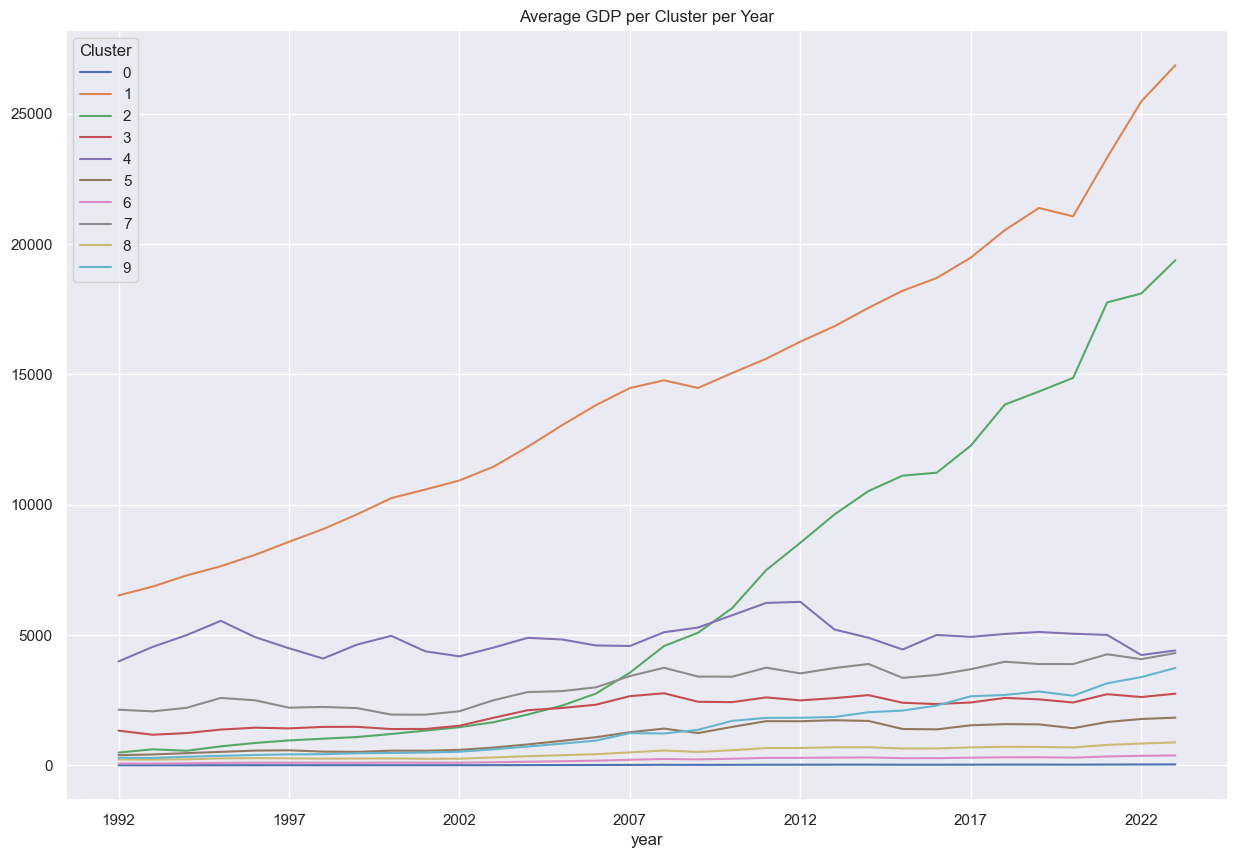

In [383]:
from sklearn.cluster import KMeans

pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform k-means clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# get average gdp per cluster per year
pivot_data_1 = pivot_data.groupby('Cluster').mean()

# display the gdp per cluster per year as a line chart
pivot_data_1.T.plot(figsize=(15, 10), title='Average GDP per Cluster per Year')

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



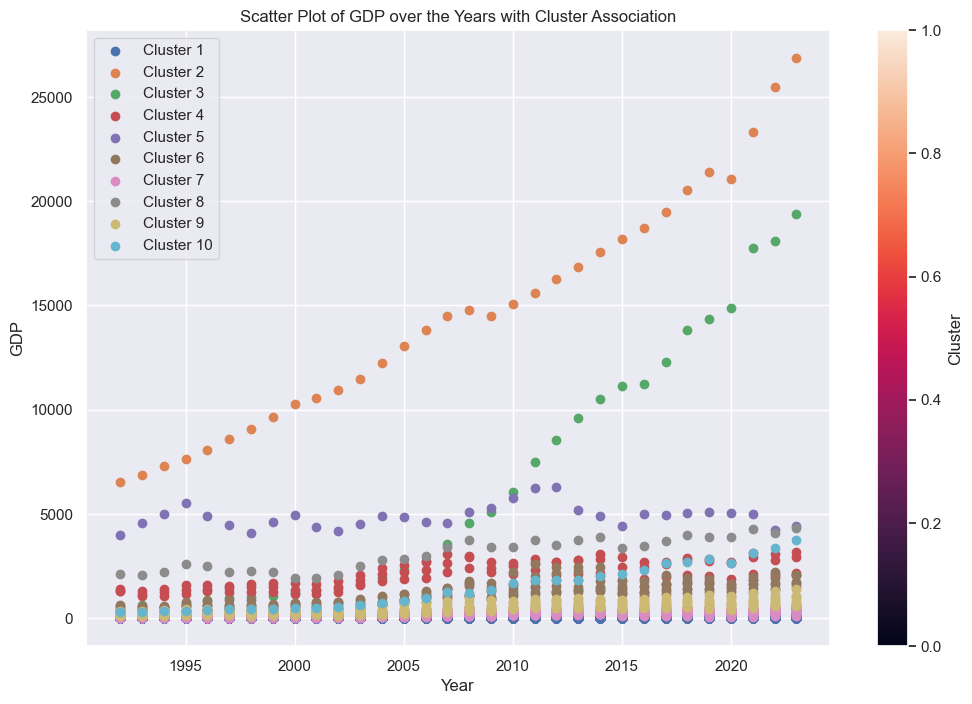

In [384]:
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Create a list to accumulate data for plot_data DataFrame
plot_data_list = []

for country in pivot_data.index:
    for year in pivot_data.columns:
        gdp_fl = pivot_data.loc[country, year]
        cluster_idx = pivot_data.index.get_loc(country)
        cluster = clusters[cluster_idx]
        plot_data_list.append({'Country': country, 'year': year, 'GDP': gdp_fl, 'Cluster': cluster})

# Create the plot_data DataFrame
plot_data = pd.DataFrame(plot_data_list)

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = plot_data[plot_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data['year'], cluster_data['GDP'], label=f'Cluster {cluster_id + 1}')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Scatter Plot of GDP over the Years with Cluster Association')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



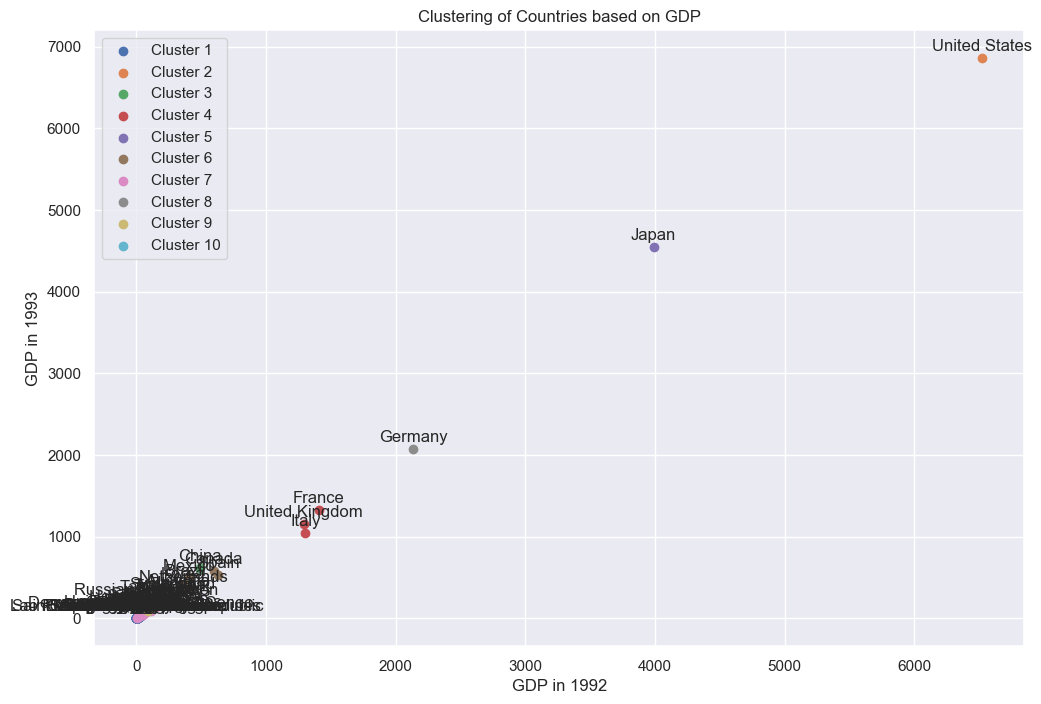

In [385]:
# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = pivot_data[pivot_data['Cluster'] == cluster_id]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster_id + 1}')

    # Add annotations (country names) near the data points
    for _, row in cluster_data.iterrows():
        plt.annotate(row.name, (row.iloc[0], row.iloc[1]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('GDP in 1992')  # Replace with an appropriate label
plt.ylabel('GDP in 1993')  # Replace with an appropriate label
plt.title('Clustering of Countries based on GDP')
plt.legend()
plt.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



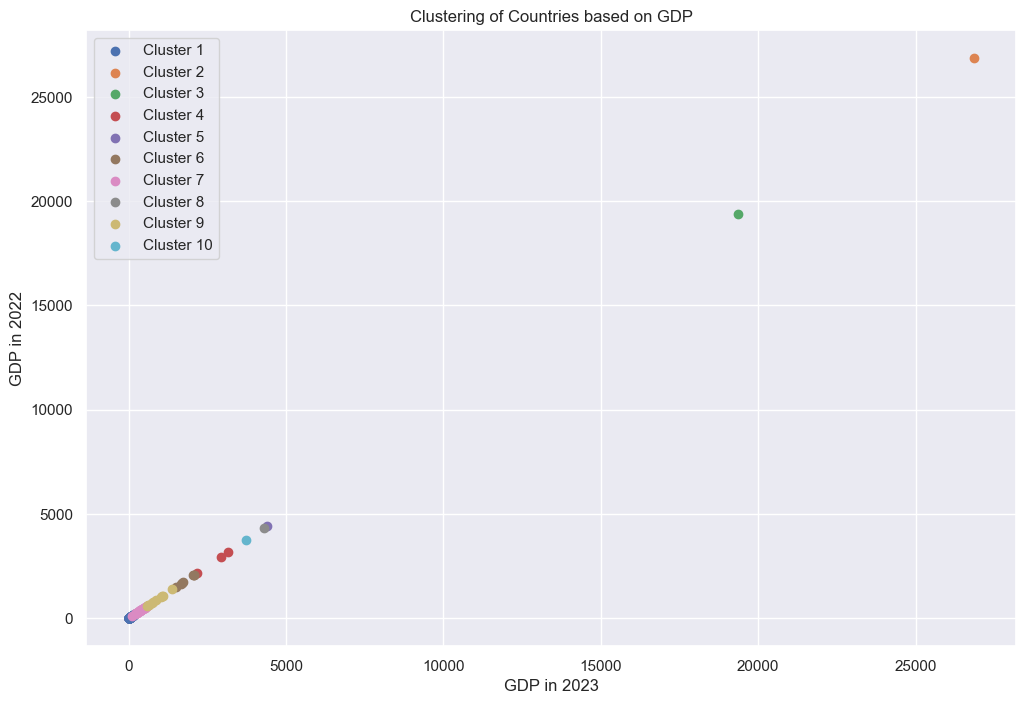

In [386]:
# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Create a scatter plot, color-coded by cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(k):
    cluster_data = pivot_data[pivot_data['Cluster'] == cluster_id]
    last_year = pivot_data.columns[-2]  # Use the last year's column, assuming the last column is 'Cluster'
    plt.scatter(cluster_data[last_year], cluster_data.iloc[:, -2], label=f'Cluster {cluster_id + 1}')

    # Add annotations (country names) near the data points
    #for _, row in cluster_data.iterrows():
    #    plt.annotate(row.name, (row[last_year], row.iloc[-2]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel(f'GDP in {last_year}')  # Replace with an appropriate label
plt.ylabel(f'GDP in {last_year - 1}')  # Replace with an appropriate label
plt.title('Clustering of Countries based on GDP')
plt.legend()
plt.show()

In [387]:
import plotly.express as px

# Create a pivot table to reshape the DataFrame (Country as index, year as columns, and GDP as values)
pivot_data = gdp.pivot(index='Country', columns='year', values='GDP')

# Perform KMeans clustering
k = 10  # Change this value to the desired number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(pivot_data)

# Add the cluster labels to the DataFrame
pivot_data['Cluster'] = clusters

# Use plotly express to create an interactive scatter plot
fig = px.scatter(pivot_data, x=pivot_data.columns[-2], y=pivot_data.columns[-3], color='Cluster',
                 hover_name=pivot_data.index)

# Update the axis labels and title
last_year = pivot_data.columns[-2]
second_last_year = pivot_data.columns[-3]
fig.update_layout(
    xaxis_title=f'GDP in {last_year}',
    yaxis_title=f'GDP in {second_last_year}',
    title='Clustering of Countries based on GDP',
    showlegend=True
)

# Show the interactive plot
fig.show()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

